### Adaboost代码模拟

#### 创建数据

In [1]:
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
from sklearn import tree
import graphviz
X = np.arange(10).reshape(-1,1)
y = np.array([1,1,1,-1,-1,-1,1,1,1,-1])
display(X,y)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1])

#### Adaboost建模

In [2]:
# 使用SAMME表示在构建树时，每棵树都采用相同的分裂方式
ada = AdaBoostClassifier(algorithm='SAMME',n_estimators=3)
ada.fit(X,y)
y_ = ada.predict(X)
display(y,y_)

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1])

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1])

#### Adaboost决策树可视化

[ 1  1  1 -1 -1 -1 -1 -1 -1 -1]


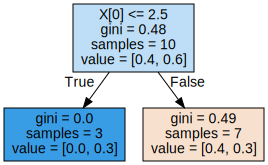

In [3]:
# 第一棵树
dot_data = tree.export_graphviz(ada[0],filled=True)
graph = graphviz.Source(dot_data)
y1_ = ada[0].predict(X)#第一棵树的预测值，怎么预测呢？
print(y1_)
graph

In [27]:
np.round(0 * 0.3 + 0.49 * 0.7,3)

0.343

[ 1  1  1  1  1  1  1  1  1 -1]


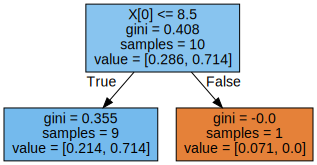

In [4]:
# 第二棵树
dot_data = tree.export_graphviz(ada[1],filled=True)
graph = graphviz.Source(dot_data)
y2_ = ada[1].predict(X)#第一棵树的预测值，怎么预测呢？
print(y2_)
graph

In [54]:
0.355 * 0.9 + 0 * 0.1

0.3195

[-1 -1 -1 -1 -1 -1  1  1  1  1]


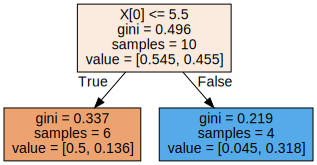

In [5]:
# 第三棵树
dot_data = tree.export_graphviz(ada[2],filled=True)
graph = graphviz.Source(dot_data)
y3_ = ada[2].predict(X)#第一棵树的预测值，怎么预测呢？
print(y3_)
graph

In [6]:
# 算法得到的权重
a1,a2,a3 = ada.estimator_weights_
print(a1,a2,a3)

0.8472978603872034 1.2992829841302609 1.5040773967762742


In [7]:
# 算法集成
result = a1 * y1_ + a2 * y2_ + a3 * y3_
result

array([ 0.64250345,  0.64250345,  0.64250345, -1.05209227, -1.05209227,
       -1.05209227,  1.95606252,  1.95606252,  1.95606252, -0.64250345])

In [8]:
# 进行类别的划分
np.sign(result).astype('int')

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1])

In [9]:
ada.predict(X)

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1])

### 第一棵树的构建

#### gini系数计算

In [10]:
# 每一个样本，权重
w1 = np.full(shape = 10,fill_value=1/10)
w1

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [13]:
# 类别是1，-1
cond = y == 1
p1 = w1[cond].sum() # 类别1 的权重，比例
gini = 0
gini += p1 * (1 - p1)

cond = y == -1 # 类别-1 的权重，比例
p2 = w1[cond].sum()
gini += p2 * (1 - p2)
gini

0.48

In [14]:
1 - p1**2 - p2**2

0.48

#### 拆分条件

In [23]:
cond = X.ravel() <= 2.5
cond.sum()/cond.size

0.3

In [24]:
gini_result = []
best_split = {} # 最佳裂分条件
lower_gini = 1 # 记录最小的gini系数
for i in range(len(X) - 1):
    split = X[i:i + 2].mean() # 裂分点
    cond = X.ravel() <= split # 裂分条件
    left = y[cond]
    right = y[~cond]
    gini_left = 0
    gini_right = 0
    for i in np.unique(y): # y in [1,-1]
        p = (left == i).sum()/left.size # 左边，某个类别的概率
        gini_left += p * (1-p)
        p = (right == i).sum()/right.size
        gini_right += p * (1-p)
    left_p = cond.sum()/cond.size # 左半部分的比例
    right_p = 1- left_p
    gini = left_p * gini_left + right_p * gini_right # 整体gini系数
    gini_result.append(gini)
    if gini < lower_gini:
        lower_gini = gini
        best_split.clear()
        best_split['X[0] <='] = split 
print(gini_result)
print(best_split)

[0.4444444444444444, 0.4, 0.3428571428571428, 0.45, 0.48, 0.45, 0.47619047619047616, 0.475, 0.4]
{'X[0] <=': 2.5}


In [28]:
np.round(0.3428571428571428,3)

0.343

In [20]:
np.unique(y)

array([-1,  1])

In [31]:
gini_result = []
best_split = {} # 最佳裂分条件
lower_gini = 1 # 记录最小的gini系数
for i in range(len(X) - 1):
    split = X[i:i + 2].mean() # 裂分点
    cond = X.ravel() <= split # 裂分条件
    # 计算的时候，左边、右边【整体】
    left_w = w1[cond]/w1[cond].sum() # 左边样本的权重，归一化处理,left_w.sum() = 1
    left_y = y[cond]
    right_w = w1[~cond]/w1[~cond].sum() # 右边样本权重，归一化处理
    right_y = y[~cond]
    gini_left = 0
    gini_right = 0
    for i in np.unique(y): # y in [1,-1]
        cond1 = left_y == i # 左边，某个类别的概率
        p = left_w[cond1].sum()
        gini_left += p * (1-p)
        cond2 = right_y == i
        p = right_w[cond2].sum()
        gini_right += p * (1-p)
    left_p = cond.sum()/cond.size # 左半部分的比例
    right_p = 1- left_p
    gini = left_p * gini_left + right_p * gini_right # 整体gini系数
    gini_result.append(gini)
    if gini < lower_gini:
        lower_gini = gini
        best_split.clear()
        best_split['X[0] <='] = split 
print(gini_result)
print(best_split)

[0.4444444444444445, 0.4, 0.3428571428571428, 0.45, 0.48, 0.45, 0.47619047619047616, 0.475, 0.39999999999999997]
{'X[0] <=': 2.5}


#### 计算误差

In [32]:
y1_ = ada[0].predict(X)
y1_

array([ 1,  1,  1, -1, -1, -1, -1, -1, -1, -1])

In [44]:
y1_ = np.array([1 if X[i] <= 2.5 else -1 for i in range(10)])
y1_

array([ 1,  1,  1, -1, -1, -1, -1, -1, -1, -1])

In [36]:
# 第一棵树的误差率，准确率 0.7
e1 = (y != np.array([1 if X[i] <= 2.5 else -1 for i in range(10)])).mean()
e1

0.3

In [42]:
w1

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

#### 计算分类器的权重

In [37]:
a1 = 1/2 * np.log((1 - e1)/e1)
a1

0.42364893019360184

In [41]:
ada.estimator_weights_/2

array([0.42364893, 0.64964149, 0.7520387 ])

#### 权重更新

In [47]:
w2 = w1 * np.exp(-a1 * y * y1_)
w2 = w2/w2.sum()
w2

array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.16666667, 0.16666667, 0.16666667, 0.07142857])

In [48]:
w2.sum()

0.9999999999999999

In [49]:
y

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1])

### 第二棵树构建

#### gini系数计算

In [50]:
# 类别是1，-1
cond = y == 1
p1 = w2[cond].sum() # 类别1 的权重，比例
gini = 0
gini += p1 * (1 - p1)

cond = y == -1 # 类别-1 的权重，比例
p2 = w2[cond].sum()
gini += p2 * (1 - p2)
gini

0.40816326530612246

In [52]:
print(np.round(p1,3),np.round(p2,3))

0.714 0.286


#### 拆分条件

In [53]:
gini_result = []
best_split = {} # 最佳裂分条件
lower_gini = 1 # 记录最小的gini系数
for i in range(len(X) - 1):
    split = X[i:i + 2].mean() # 裂分点
    cond = X.ravel() <= split # 裂分条件
    # 计算的时候，左边、右边【整体】
    left_w = w2[cond]/w2[cond].sum() # 左边样本的权重，归一化处理,left_w.sum() = 1
    left_y = y[cond]
    right_w = w2[~cond]/w2[~cond].sum() # 右边样本权重，归一化处理
    right_y = y[~cond]
    gini_left = 0
    gini_right = 0
    for i in np.unique(y): # y in [1,-1]
        cond1 = left_y == i # 左边，某个类别的概率
        p = left_w[cond1].sum()
        gini_left += p * (1-p)
        cond2 = right_y == i
        p = right_w[cond2].sum()
        gini_right += p * (1-p)
    left_p = cond.sum()/cond.size # 左半部分的比例
    right_p = 1- left_p
    gini = left_p * gini_left + right_p * gini_right # 整体gini系数
    gini_result.append(gini)
    if gini < lower_gini:
        lower_gini = gini
        best_split.clear()
        best_split['X[0] <='] = split 
print(gini_result)
print(best_split)

[0.38343195266272184, 0.35555555555555557, 0.3239669421487603, 0.40199999999999997, 0.4128395061728395, 0.38749999999999996, 0.40975723183391, 0.4074375, 0.3195266272189349]
{'X[0] <=': 8.5}


#### 计算误差

In [55]:
y2_ = np.array([1 if X[i] <= 8.5 else -1 for i in range(10)])
y2_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, -1])

In [57]:
e2 = ((y != y2_) * w2).sum()
e2

0.21428571428571425

In [61]:
ada.estimator_errors_

array([0.3       , 0.21428571, 0.18181818])

#### 计算分类器的权重

In [58]:
a2 = 1/2 * np.log((1 - e2)/e2)
a2

0.6496414920651306

In [60]:
ada.estimator_weights_/2

array([0.42364893, 0.64964149, 0.7520387 ])

#### 权重更新

In [62]:
w3 = w2 * np.exp(-a2 * y * y2_)
w3 = w3/w3.sum()
w3

array([0.04545455, 0.04545455, 0.04545455, 0.16666667, 0.16666667,
       0.16666667, 0.10606061, 0.10606061, 0.10606061, 0.04545455])

### 第三棵树构建

#### gini系数计算

In [63]:
# 类别是1，-1
cond = y == 1
p1 = w3[cond].sum() # 类别1 的权重，比例
gini = 0
gini += p1 * (1 - p1)

cond = y == -1 # 类别-1 的权重，比例
p2 = w3[cond].sum()
gini += p2 * (1 - p2)
gini

0.49586776859504134

In [64]:
print(np.round(p1,3),np.round(p2,3))

0.455 0.545


#### 拆分条件

In [65]:
gini_result = []
best_split = {} # 最佳裂分条件
lower_gini = 1 # 记录最小的gini系数
for i in range(len(X) - 1):
    split = X[i:i + 2].mean() # 裂分点
    cond = X.ravel() <= split # 裂分条件
    # 计算的时候，左边、右边【整体】
    left_w = w3[cond]/w3[cond].sum() # 左边样本的权重，归一化处理,left_w.sum() = 1
    left_y = y[cond]
    right_w = w3[~cond]/w3[~cond].sum() # 右边样本权重，归一化处理
    right_y = y[~cond]
    gini_left = 0
    gini_right = 0
    for i in np.unique(y): # y in [1,-1]
        cond1 = left_y == i # 左边，某个类别的概率
        p = left_w[cond1].sum()
        gini_left += p * (1-p)
        cond2 = right_y == i
        p = right_w[cond2].sum()
        gini_right += p * (1-p)
    left_p = cond.sum()/cond.size # 左半部分的比例
    right_p = 1- left_p
    gini = left_p * gini_left + right_p * gini_right # 整体gini系数
    gini_result.append(gini)
    if gini < lower_gini:
        lower_gini = gini
        best_split.clear()
        best_split['X[0] <='] = split 
print(gini_result)
print(best_split)

[0.44081632653061226, 0.384, 0.3257617728531856, 0.49573156899810966, 0.4460353798126951, 0.28954081632653056, 0.39506895195052805, 0.4712448979591837, 0.44897959183673475]
{'X[0] <=': 5.5}


#### 计算误差

In [66]:
y3_ = np.array([-1 if X[i] <= 5.5 else 1 for i in range(10)])
y3_

array([-1, -1, -1, -1, -1, -1,  1,  1,  1,  1])

In [67]:
e3 = ((y != y3_) * w3).sum()
e3

0.1818181818181818

In [68]:
ada.estimator_errors_

array([0.3       , 0.21428571, 0.18181818])

#### 算法权重

In [69]:
a3 = 1/2 * np.log((1 - e3)/e3)
a3

0.7520386983881371

#### 权重更新

In [70]:
w4 = w3 * np.exp(-a3 * y * y3_)
w4 = w4/w4.sum()
w4

array([0.125     , 0.125     , 0.125     , 0.10185185, 0.10185185,
       0.10185185, 0.06481481, 0.06481481, 0.06481481, 0.125     ])

### 弱学习器融合

In [71]:
result = a1 * y1_ + a2 * y2_ + a3 * y3_
result

array([ 0.32125172,  0.32125172,  0.32125172, -0.52604614, -0.52604614,
       -0.52604614,  0.97803126,  0.97803126,  0.97803126, -0.32125172])

In [73]:
y_ = np.sign(result)
y_.astype(np.int8)

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1], dtype=int8)

In [74]:
ada.predict(X)

array([ 1,  1,  1, -1, -1, -1,  1,  1,  1, -1])

### 算法 VS 自己手写的代码

In [75]:
ada.estimator_errors_

array([0.3       , 0.21428571, 0.18181818])

In [77]:
print(e1,np.round(e2,8),np.round(e3,8))

0.3 0.21428571 0.18181818


In [79]:
ada.estimator_weights_/2

array([0.42364893, 0.64964149, 0.7520387 ])

In [80]:
print(np.round(a1,8),np.round(a2,8),np.round(a3,8))

0.42364893 0.64964149 0.7520387


#### 概率计算

In [81]:
ada.predict_proba(X)

array([[0.45611407, 0.54388593],
       [0.45611407, 0.54388593],
       [0.45611407, 0.54388593],
       [0.57155357, 0.42844643],
       [0.57155357, 0.42844643],
       [0.57155357, 0.42844643],
       [0.36916261, 0.63083739],
       [0.36916261, 0.63083739],
       [0.36916261, 0.63083739],
       [0.54388593, 0.45611407]])

In [82]:
y1_

array([ 1,  1,  1, -1, -1, -1, -1, -1, -1, -1])

In [88]:
ada[0].predict(X)

array([ 1,  1,  1, -1, -1, -1, -1, -1, -1, -1])

In [89]:
y1_ = (ada[0].predict(X) == np.array([[-1],[1]])).T.astype(np.int8)
y2_ = (ada[1].predict(X) == np.array([[-1],[1]])).T.astype(np.int8)
y3_ = (ada[2].predict(X) == np.array([[-1],[1]])).T.astype(np.int8)
display(y1_,y2_,y3_)

array([[0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int8)

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0]], dtype=int8)

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int8)

In [90]:
pred = y1_ * a1 * 2 + y2_ * a2 * 2 + y3_ * a3 * 2
pred

array([[1.5040774 , 2.14658084],
       [1.5040774 , 2.14658084],
       [1.5040774 , 2.14658084],
       [2.35137526, 1.29928298],
       [2.35137526, 1.29928298],
       [2.35137526, 1.29928298],
       [0.84729786, 2.80336038],
       [0.84729786, 2.80336038],
       [0.84729786, 2.80336038],
       [2.14658084, 1.5040774 ]])

In [91]:
pred /= ((a1 + a2 + a3)*2)
pred

array([[0.4120017 , 0.5879983 ],
       [0.4120017 , 0.5879983 ],
       [0.4120017 , 0.5879983 ],
       [0.64409624, 0.35590376],
       [0.64409624, 0.35590376],
       [0.64409624, 0.35590376],
       [0.23209454, 0.76790546],
       [0.23209454, 0.76790546],
       [0.23209454, 0.76790546],
       [0.5879983 , 0.4120017 ]])

In [92]:
pred[:,0] *= -1 # 第一列，正负翻转，第一列是-1
pred

array([[-0.4120017 ,  0.5879983 ],
       [-0.4120017 ,  0.5879983 ],
       [-0.4120017 ,  0.5879983 ],
       [-0.64409624,  0.35590376],
       [-0.64409624,  0.35590376],
       [-0.64409624,  0.35590376],
       [-0.23209454,  0.76790546],
       [-0.23209454,  0.76790546],
       [-0.23209454,  0.76790546],
       [-0.5879983 ,  0.4120017 ]])

In [93]:
pred = pred.sum(axis = 1)
pred

array([ 0.1759966 ,  0.1759966 ,  0.1759966 , -0.28819249, -0.28819249,
       -0.28819249,  0.53581091,  0.53581091,  0.53581091, -0.1759966 ])

In [94]:
# 水平堆叠

In [95]:
pred = np.vstack([-pred,pred]).T/2
pred

array([[-0.0879983 ,  0.0879983 ],
       [-0.0879983 ,  0.0879983 ],
       [-0.0879983 ,  0.0879983 ],
       [ 0.14409624, -0.14409624],
       [ 0.14409624, -0.14409624],
       [ 0.14409624, -0.14409624],
       [-0.26790546,  0.26790546],
       [-0.26790546,  0.26790546],
       [-0.26790546,  0.26790546],
       [ 0.0879983 , -0.0879983 ]])

In [96]:
np.exp(pred)/(np.exp(pred).sum(axis = 1).reshape(-1,1))

array([[0.45611407, 0.54388593],
       [0.45611407, 0.54388593],
       [0.45611407, 0.54388593],
       [0.57155357, 0.42844643],
       [0.57155357, 0.42844643],
       [0.57155357, 0.42844643],
       [0.36916261, 0.63083739],
       [0.36916261, 0.63083739],
       [0.36916261, 0.63083739],
       [0.54388593, 0.45611407]])

In [97]:
ada.predict_proba(X)

array([[0.45611407, 0.54388593],
       [0.45611407, 0.54388593],
       [0.45611407, 0.54388593],
       [0.57155357, 0.42844643],
       [0.57155357, 0.42844643],
       [0.57155357, 0.42844643],
       [0.36916261, 0.63083739],
       [0.36916261, 0.63083739],
       [0.36916261, 0.63083739],
       [0.54388593, 0.45611407]])